# DQN для Lunar Lander

В этом ноутбуке реализован алгоритм Deep Q-Network (DQN) для обучения агента в среде Lunar Lander.

## Основные компоненты:
1. Replay Buffer для хранения опыта
2. Q-Network (нейронная сеть для аппроксимации Q-функции)
3. Target Network (целевая сеть с мягким обновлением)
4. DQN агент с epsilon-greedy стратегией

In [1]:
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from collections import deque
import random
from typing import List, Tuple

# Установка seed для воспроизводимости
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# Проверка доступности GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Используется устройство: {device}")

Используется устройство: cpu


## 1. Replay Buffer

Replay Buffer хранит опыт агента и позволяет сэмплировать случайные батчи для обучения. Это помогает разбить корреляцию между последовательными наблюдениями.

In [2]:
class ReplayBuffer:
    """Replay Buffer для хранения и сэмплирования опыта."""
    
    def __init__(self, capacity: int):
        """Инициализация буфера.
        
        Args:
            capacity: Максимальный размер буфера
        """
        self.buffer = deque(maxlen=capacity)
    
    def push(self, state: np.ndarray, action: int, reward: float, 
             next_state: np.ndarray, done: bool) -> None:
        """Добавление нового опыта в буфер.
        
        Args:
            state: Текущее состояние
            action: Выполненное действие
            reward: Полученная награда
            next_state: Следующее состояние
            done: Флаг окончания эпизода
        """
        self.buffer.append((state, action, reward, next_state, done))
    
    def sample(self, batch_size: int) -> Tuple[torch.Tensor, ...]:
        """Случайная выборка батча из буфера.
        
        Args:
            batch_size: Размер батча
            
        Returns:
            Кортеж тензоров (states, actions, rewards, next_states, dones)
        """
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        
        return (
            torch.FloatTensor(np.array(states)).to(device),
            torch.LongTensor(actions).to(device),
            torch.FloatTensor(rewards).to(device),
            torch.FloatTensor(np.array(next_states)).to(device),
            torch.FloatTensor(dones).to(device)
        )
    
    def __len__(self) -> int:
        """Возвращает текущий размер буфера."""
        return len(self.buffer)

## 2. Q-Network

Нейронная сеть для аппроксимации Q-функции. Использует полносвязные слои с ReLU активацией.

In [3]:
class QNetwork(nn.Module):
    """Нейронная сеть для аппроксимации Q-функции."""
    
    def __init__(self, state_dim: int, action_dim: int, hidden_dim: int = 128):
        """Инициализация сети.
        
        Args:
            state_dim: Размерность пространства состояний
            action_dim: Размерность пространства действий
            hidden_dim: Размер скрытых слоев
        """
        super(QNetwork, self).__init__()
        
        self.network = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, action_dim)
        )
    
    def forward(self, state: torch.Tensor) -> torch.Tensor:
        """Прямой проход через сеть.
        
        Args:
            state: Тензор состояний
            
        Returns:
            Q-значения для каждого действия
        """
        return self.network(state)

## 3. DQN Agent

Агент, реализующий алгоритм DQN с:
- Replay Buffer
- Target Network с мягким обновлением (soft update)
- Epsilon-greedy стратегией исследования

In [4]:
class DQNAgent:
    """DQN агент с replay buffer и мягким обновлением целевой сети."""
    
    def __init__(
        self,
        state_dim: int,
        action_dim: int,
        hidden_dim: int = 128,
        buffer_capacity: int = 100000,
        batch_size: int = 64,
        gamma: float = 0.99,
        lr: float = 1e-3,
        tau: float = 0.005,
        epsilon_start: float = 1.0,
        epsilon_end: float = 0.01,
        epsilon_decay: float = 0.995
    ):
        """Инициализация агента.
        
        Args:
            state_dim: Размерность пространства состояний
            action_dim: Размерность пространства действий
            hidden_dim: Размер скрытых слоев сети
            buffer_capacity: Размер replay buffer
            batch_size: Размер батча для обучения
            gamma: Коэффициент дисконтирования
            lr: Скорость обучения
            tau: Коэффициент мягкого обновления целевой сети
            epsilon_start: Начальное значение epsilon
            epsilon_end: Конечное значение epsilon
            epsilon_decay: Коэффициент уменьшения epsilon
        """
        self.action_dim = action_dim
        self.batch_size = batch_size
        self.gamma = gamma
        self.tau = tau
        self.epsilon = epsilon_start
        self.epsilon_end = epsilon_end
        self.epsilon_decay = epsilon_decay
        
        # Создание основной и целевой сетей
        self.q_network = QNetwork(state_dim, action_dim, hidden_dim).to(device)
        self.target_network = QNetwork(state_dim, action_dim, hidden_dim).to(device)
        self.target_network.load_state_dict(self.q_network.state_dict())
        
        # Оптимизатор и функция потерь
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=lr)
        self.criterion = nn.MSELoss()
        
        # Replay buffer
        self.replay_buffer = ReplayBuffer(buffer_capacity)
    
    def select_action(self, state: np.ndarray, training: bool = True) -> int:
        """Выбор действия с использованием epsilon-greedy стратегии.
        
        Args:
            state: Текущее состояние
            training: Флаг режима обучения
            
        Returns:
            Выбранное действие
        """
        if training and random.random() < self.epsilon:
            return random.randrange(self.action_dim)
        
        with torch.no_grad():
            state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
            q_values = self.q_network(state_tensor)
            return q_values.argmax().item()
    
    def train_step(self) -> float:
        """Один шаг обучения агента.
        
        Returns:
            Значение функции потерь
        """
        if len(self.replay_buffer) < self.batch_size:
            return 0.0
        
        # Сэмплирование батча из replay buffer
        states, actions, rewards, next_states, dones = self.replay_buffer.sample(self.batch_size)
        
        # Вычисление текущих Q-значений
        current_q_values = self.q_network(states).gather(1, actions.unsqueeze(1)).squeeze(1)
        
        # Вычисление целевых Q-значений с использованием target network
        with torch.no_grad():
            next_q_values = self.target_network(next_states).max(1)[0]
            target_q_values = rewards + (1 - dones) * self.gamma * next_q_values
        
        # Вычисление функции потерь и обратное распространение
        loss = self.criterion(current_q_values, target_q_values)
        
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        # Мягкое обновление целевой сети
        self.soft_update_target_network()
        
        return loss.item()
    
    def soft_update_target_network(self) -> None:
        """Мягкое обновление параметров целевой сети.
        
        θ_target = τ * θ_local + (1 - τ) * θ_target
        """
        for target_param, local_param in zip(
            self.target_network.parameters(), 
            self.q_network.parameters()
        ):
            target_param.data.copy_(
                self.tau * local_param.data + (1.0 - self.tau) * target_param.data
            )
    
    def decay_epsilon(self) -> None:
        """Уменьшение epsilon для epsilon-greedy стратегии."""
        self.epsilon = max(self.epsilon_end, self.epsilon * self.epsilon_decay)
    
    def save(self, filepath: str) -> None:
        """Сохранение весов модели.
        
        Args:
            filepath: Путь к файлу для сохранения
        """
        torch.save({
            'q_network_state_dict': self.q_network.state_dict(),
            'target_network_state_dict': self.target_network.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
        }, filepath)
    
    def load(self, filepath: str) -> None:
        """Загрузка весов модели.
        
        Args:
            filepath: Путь к файлу с весами
        """
        checkpoint = torch.load(filepath, map_location=device, weights_only=True)
        self.q_network.load_state_dict(checkpoint['q_network_state_dict'])
        self.target_network.load_state_dict(checkpoint['target_network_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

## 4. Функция обучения

Основной цикл обучения агента в среде Lunar Lander.

In [5]:
def train_dqn(
    env_name: str = "LunarLander-v3",
    num_episodes: int = 600,
    max_steps: int = 1000,
    print_every: int = 50
) -> Tuple[DQNAgent, List[float], List[float]]:
    """Обучение DQN агента.
    
    Args:
        env_name: Название среды Gymnasium
        num_episodes: Количество эпизодов обучения
        max_steps: Максимальное количество шагов в эпизоде
        print_every: Частота вывода информации об обучении
        
    Returns:
        Кортеж (обученный агент, награды за эпизоды, средние награды за 100 эпизодов)
    """
    # Создание среды
    env = gym.make(env_name)
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.n
    
    print(f"Размерность состояния: {state_dim}")
    print(f"Количество действий: {action_dim}")
    print(f"\nНачало обучения на {num_episodes} эпизодов...\n")
    
    # Создание агента
    agent = DQNAgent(
        state_dim=state_dim,
        action_dim=action_dim,
        hidden_dim=128,
        buffer_capacity=100000,
        batch_size=64,
        gamma=0.99,
        lr=1e-3,
        tau=0.005,
        epsilon_start=1.0,
        epsilon_end=0.01,
        epsilon_decay=0.995
    )
    
    # Списки для отслеживания прогресса
    episode_rewards = []
    avg_rewards = []
    
    # Основной цикл обучения
    for episode in range(num_episodes):
        state, _ = env.reset(seed=SEED + episode)
        episode_reward = 0
        
        for step in range(max_steps):
            # Выбор и выполнение действия
            action = agent.select_action(state, training=True)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            
            # Сохранение опыта в replay buffer
            agent.replay_buffer.push(state, action, reward, next_state, float(done))
            
            # Обучение агента
            agent.train_step()
            
            episode_reward += reward
            state = next_state
            
            if done:
                break
        
        # Уменьшение epsilon
        agent.decay_epsilon()
        
        # Сохранение результатов
        episode_rewards.append(episode_reward)
        avg_reward = np.mean(episode_rewards[-100:]) if len(episode_rewards) >= 100 else np.mean(episode_rewards)
        avg_rewards.append(avg_reward)
        
        # Вывод информации
        if (episode + 1) % print_every == 0:
            print(f"Эпизод {episode + 1}/{num_episodes} | "
                  f"Награда: {episode_reward:.2f} | "
                  f"Средняя награда (100 эп.): {avg_reward:.2f} | "
                  f"Epsilon: {agent.epsilon:.3f}")
    
    env.close()
    print("\nОбучение завершено!")
    
    return agent, episode_rewards, avg_rewards

## 5. Визуализация результатов

Функция для построения графиков обучения.

In [6]:
def plot_training_results(episode_rewards: List[float], avg_rewards: List[float]) -> None:
    """Построение графиков результатов обучения.
    
    Args:
        episode_rewards: Награды за каждый эпизод
        avg_rewards: Средние награды за последние 100 эпизодов
    """
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
    
    # График наград за эпизоды
    ax1.plot(episode_rewards, alpha=0.6, linewidth=1)
    ax1.set_xlabel('Эпизод', fontsize=12)
    ax1.set_ylabel('Награда за эпизод', fontsize=12)
    ax1.set_title('Награда за эпизод в процессе обучения', fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    ax1.axhline(y=200, color='r', linestyle='--', linewidth=2, label='Целевая награда (200)')
    ax1.legend()
    
    # График средних наград за 100 эпизодов
    ax2.plot(avg_rewards, color='orange', linewidth=2)
    ax2.set_xlabel('Эпизод', fontsize=12)
    ax2.set_ylabel('Средняя награда за 100 эпизодов', fontsize=12)
    ax2.set_title('Средняя награда за последние 100 эпизодов', fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    ax2.axhline(y=200, color='r', linestyle='--', linewidth=2, label='Целевая награда (200)')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Вывод статистики
    print(f"\nСтатистика обучения:")
    print(f"Максимальная награда за эпизод: {max(episode_rewards):.2f}")
    print(f"Минимальная награда за эпизод: {min(episode_rewards):.2f}")
    print(f"Средняя награда за все эпизоды: {np.mean(episode_rewards):.2f}")
    print(f"Средняя награда за последние 100 эпизодов: {avg_rewards[-1]:.2f}")

## 6. Тестирование обученного агента

Функция для оценки производительности обученного агента.

In [7]:
def test_agent(agent: DQNAgent, env_name: str = "LunarLander-v3", 
               num_episodes: int = 10, render: bool = False) -> float:
    """Тестирование обученного агента.
    
    Args:
        agent: Обученный DQN агент
        env_name: Название среды
        num_episodes: Количество тестовых эпизодов
        render: Флаг отрисовки среды
        
    Returns:
        Средняя награда за тестовые эпизоды
    """
    if render:
        env = gym.make(env_name, render_mode="human")
    else:
        env = gym.make(env_name)
    
    test_rewards = []
    
    print(f"\nТестирование агента на {num_episodes} эпизодах...\n")
    
    for episode in range(num_episodes):
        state, _ = env.reset(seed=SEED + episode)
        episode_reward = 0
        done = False
        
        while not done:
            action = agent.select_action(state, training=False)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            episode_reward += reward
            state = next_state
        
        test_rewards.append(episode_reward)
        print(f"Тестовый эпизод {episode + 1}: Награда = {episode_reward:.2f}")
    
    env.close()
    
    avg_test_reward = np.mean(test_rewards)
    print(f"\nСредняя награда за {num_episodes} тестовых эпизодов: {avg_test_reward:.2f}")
    
    return avg_test_reward

## 7. Обучение агента

Запускаем процесс обучения DQN агента в среде Lunar Lander.

In [8]:
# Обучение агента
agent, episode_rewards, avg_rewards = train_dqn(
    env_name="LunarLander-v3",
    num_episodes=600,
    max_steps=1000,
    print_every=50
)

Размерность состояния: 8
Количество действий: 4

Начало обучения на 600 эпизодов...



c:\Users\pndvg\repos\RL-Otus\Otus-RL-homework\.venv\Lib\site-packages\pygame\pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists


Эпизод 50/600 | Награда: -95.75 | Средняя награда (100 эп.): -146.19 | Epsilon: 0.778
Эпизод 100/600 | Награда: -56.46 | Средняя награда (100 эп.): -115.62 | Epsilon: 0.606
Эпизод 150/600 | Награда: -33.92 | Средняя награда (100 эп.): -70.07 | Epsilon: 0.471
Эпизод 200/600 | Награда: 7.37 | Средняя награда (100 эп.): -56.26 | Epsilon: 0.367
Эпизод 250/600 | Награда: -2.96 | Средняя награда (100 эп.): -19.78 | Epsilon: 0.286
Эпизод 300/600 | Награда: 45.09 | Средняя награда (100 эп.): 41.31 | Epsilon: 0.222
Эпизод 350/600 | Награда: -36.82 | Средняя награда (100 эп.): 92.87 | Epsilon: 0.173
Эпизод 400/600 | Награда: 259.94 | Средняя награда (100 эп.): 100.66 | Epsilon: 0.135
Эпизод 450/600 | Награда: 283.30 | Средняя награда (100 эп.): 123.30 | Epsilon: 0.105
Эпизод 500/600 | Награда: 236.41 | Средняя награда (100 эп.): 197.04 | Epsilon: 0.082
Эпизод 550/600 | Награда: 245.23 | Средняя награда (100 эп.): 230.90 | Epsilon: 0.063
Эпизод 600/600 | Награда: 181.73 | Средняя награда (100 эп.

## 8. Визуализация результатов обучения

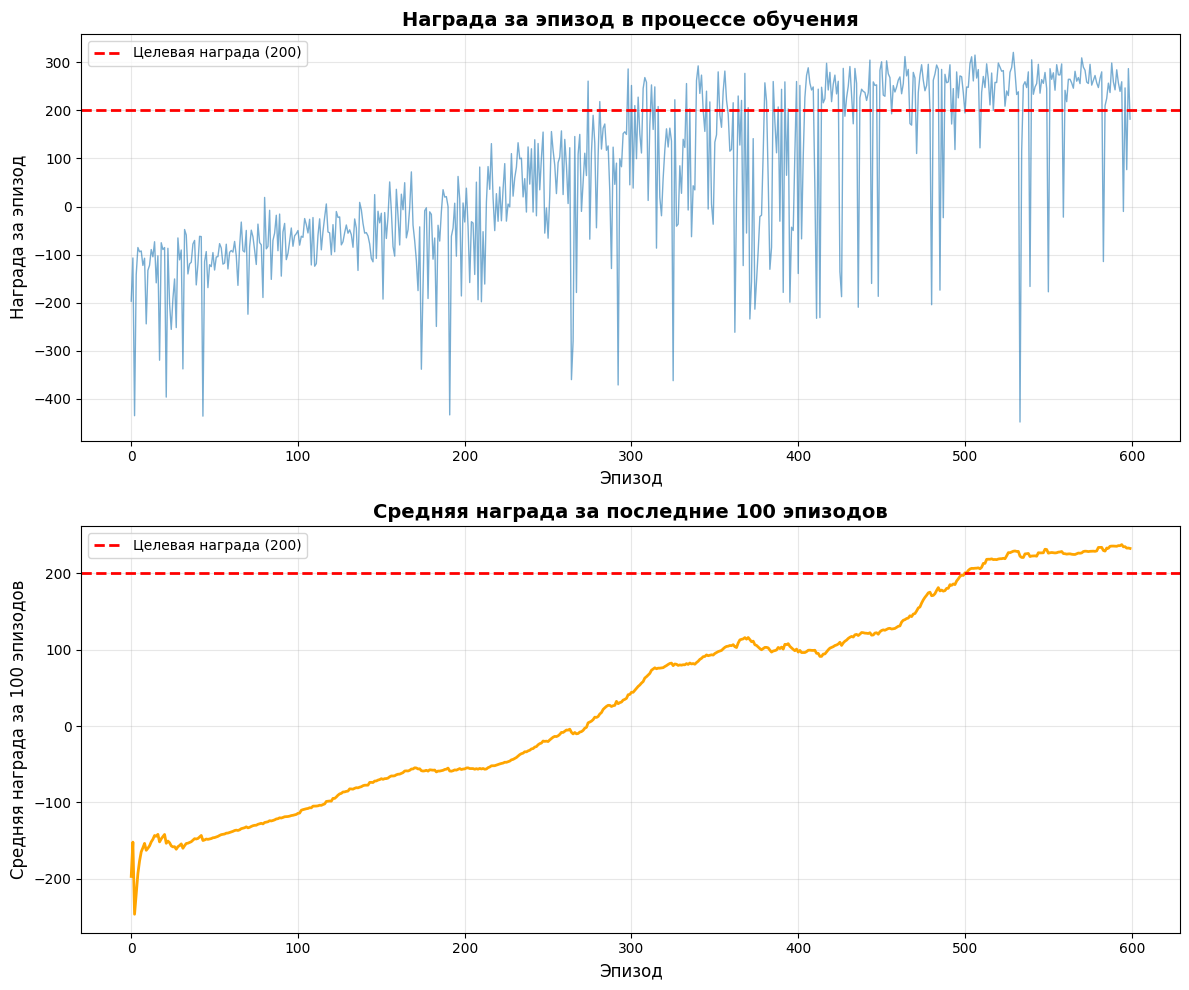


Статистика обучения:
Максимальная награда за эпизод: 320.51
Минимальная награда за эпизод: -448.07
Средняя награда за все эпизоды: 66.58
Средняя награда за последние 100 эпизодов: 232.33


In [9]:
# Построение графиков
plot_training_results(episode_rewards, avg_rewards)

## 9. Сохранение обученного агента

In [12]:
# Сохранение модели
agent.save('../results/models/lunar_lander_dqn.pth')
print("Модель сохранена в файл 'lunar_lander_dqn.pth'")

Модель сохранена в файл 'lunar_lander_dqn.pth'


## 10. Тестирование обученного агента

In [15]:
# Тестирование агента
avg_test_reward = test_agent(agent, num_episodes=10, render=False)


Тестирование агента на 10 эпизодах...

Тестовый эпизод 1: Награда = 126.07
Тестовый эпизод 2: Награда = 217.69
Тестовый эпизод 3: Награда = 261.04
Тестовый эпизод 4: Награда = 234.16
Тестовый эпизод 5: Награда = 276.07
Тестовый эпизод 6: Награда = 260.48
Тестовый эпизод 7: Награда = 234.91
Тестовый эпизод 8: Награда = 243.39
Тестовый эпизод 9: Награда = 257.54
Тестовый эпизод 10: Награда = 274.18

Средняя награда за 10 тестовых эпизодов: 238.55


## Выводы

В этом ноутбуке была реализована полная версия алгоритма DQN для обучения агента в среде Lunar Lander.

### Основные компоненты реализации:

1. **Replay Buffer**: Сохраняет опыт агента и позволяет сэмплировать случайные батчи, разбивая корреляцию между последовательными наблюдениями.

2. **Q-Network**: Полносвязная нейронная сеть с двумя скрытыми слоями для аппроксимации Q-функции.

3. **Target Network**: Отдельная целевая сеть, которая обновляется мягко (soft update) с параметром τ = 0.005. Это стабилизирует обучение.

4. **Epsilon-Greedy**: Стратегия исследования, начинающаяся с ε = 1.0 и постепенно уменьшающаяся до ε = 0.01.

### Гиперпараметры:
- Размер replay buffer: 100,000
- Размер батча: 64
- Коэффициент дисконтирования γ: 0.99
- Скорость обучения: 0.001
- Параметр мягкого обновления τ: 0.005
- Количество эпизодов: 600

### Ожидаемые результаты:
- Агент должен показывать рост средней награды по мере обучения
- Целевая награда для решения задачи Lunar Lander: 200+
- График должен демонстрировать стабильное улучшение производительности